Train: (6000, 256) (6000, 256)
Test : (800, 256) (800, 256)


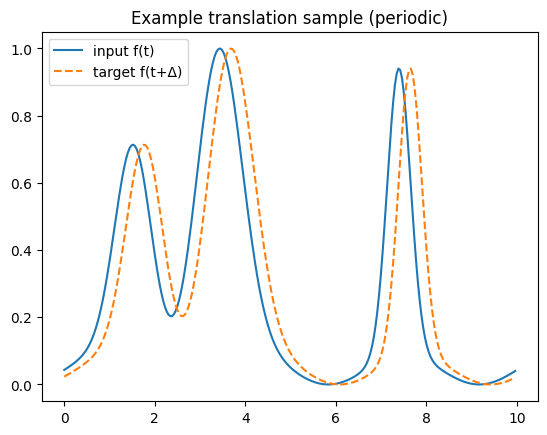

In [1]:
# ============================================================
# Cell 1: Synthetic periodic blob translation dataset (1D)
# ============================================================
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(42)

# Domain
L = 10.0
N = 256
x = np.linspace(0.0, L, N, endpoint=False)
dx = x[1] - x[0]

def periodic_shift(f, shift):
    """Shift f(x) by shift in x (periodic), using Fourier shift theorem."""
    k = 2*np.pi*np.fft.fftfreq(N, d=dx)
    F = np.fft.fft(f)
    return np.real(np.fft.ifft(F * np.exp(-1j*k*shift)))

def make_blob(x, center, width, amp=1.0):
    """Gaussian blob on periodic domain (but evaluated in Euclidean distance)."""
    # periodic distance
    d = np.minimum(np.abs(x-center), L-np.abs(x-center))
    return amp * np.exp(-(d**2)/(2*width**2))

def sample_function():
    """Create a function with 1-3 blobs + small background oscillation."""
    f = np.zeros_like(x)
    nb = rng.integers(1, 4)
    for _ in range(nb):
        c = rng.uniform(0, L)
        w = rng.uniform(0.15, 0.6)
        a = rng.uniform(0.6, 1.2)
        f += make_blob(x, c, w, a)
    # small periodic wave background
    f += 0.05*np.sin(2*np.pi*x/L * rng.integers(1, 4))
    # normalize to [0,1] roughly
    f = f - f.min()
    f = f / (f.max() + 1e-12)
    return f

# Dataset parameters
n_train = 6000
n_test  = 800
dt_shift = 0.25   # amount of translation per step (in x units)

def make_dataset(n):
    X = np.zeros((n, N), dtype=np.float32)
    Y = np.zeros((n, N), dtype=np.float32)
    for i in range(n):
        f0 = sample_function()
        # randomly choose a direction and magnitude around dt_shift
        shift = dt_shift          # fixed translation for all samples
        f1 = periodic_shift(f0, shift)
        X[i] = f0
        Y[i] = f1
    return X, Y

X_train, Y_train = make_dataset(n_train)
X_test,  Y_test  = make_dataset(n_test)

print("Train:", X_train.shape, Y_train.shape)
print("Test :", X_test.shape,  Y_test.shape)

# Quick preview
idx = rng.integers(0, n_train)
plt.figure()
plt.plot(x, X_train[idx], label="input f(t)")
plt.plot(x, Y_train[idx], label="target f(t+Δ)", linestyle="--")
plt.title("Example translation sample (periodic)")
plt.legend()
plt.show()


In [2]:
# ============================================================
# Cell 2: Define a small CNN forecaster (1D)
# ============================================================
import torch
import torch.nn as nn
import torch.nn.functional as F

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print("device:", device)
print("device:", device)

class PeriodicConv1d(nn.Module):
    """Conv1d with circular padding."""
    def __init__(self, in_ch, out_ch, k=5):
        super().__init__()
        self.k = k
        self.conv = nn.Conv1d(in_ch, out_ch, kernel_size=k, padding=0)

    def forward(self, x):
        # x shape: (B,C,N)
        pad = self.k // 2
        x = torch.cat([x[..., -pad:], x, x[..., :pad]], dim=-1)
        return self.conv(x)

class TinyForecaster(nn.Module):
    def __init__(self, width=32):
        super().__init__()
        self.c1 = PeriodicConv1d(1, width, k=7)
        self.c2 = PeriodicConv1d(width, width, k=7)
        self.c3 = PeriodicConv1d(width, width, k=7)
        self.out = PeriodicConv1d(width, 1, k=7)

    def forward(self, x):
        # x: (B,1,N)
        h1 = F.relu(self.c1(x))
        h2 = F.relu(self.c2(h1))
        h3 = F.relu(self.c3(h2))
        y  = self.out(h3)
        return y, {"h1": h1, "h2": h2, "h3": h3}

model = TinyForecaster(width=32).to(device)
n_params = sum(p.numel() for p in model.parameters())
print("Params:", n_params)


device: mps
device: mps
Params: 14881


ep 01 | train 6.1111e-03 | test 2.9052e-05
ep 02 | train 1.7665e-05 | test 1.0955e-05
ep 03 | train 9.7659e-06 | test 9.0552e-06
ep 04 | train 8.1073e-06 | test 7.3926e-06
ep 05 | train 7.1698e-06 | test 6.2886e-06
ep 06 | train 6.5002e-06 | test 5.6826e-06
ep 07 | train 5.9522e-06 | test 5.7529e-06
ep 08 | train 6.7439e-06 | test 5.5349e-06
ep 09 | train 5.6167e-06 | test 4.8731e-06
ep 10 | train 1.1825e-05 | test 5.7052e-06
ep 11 | train 5.9710e-06 | test 9.9380e-06
ep 12 | train 1.8984e-05 | test 2.6491e-06


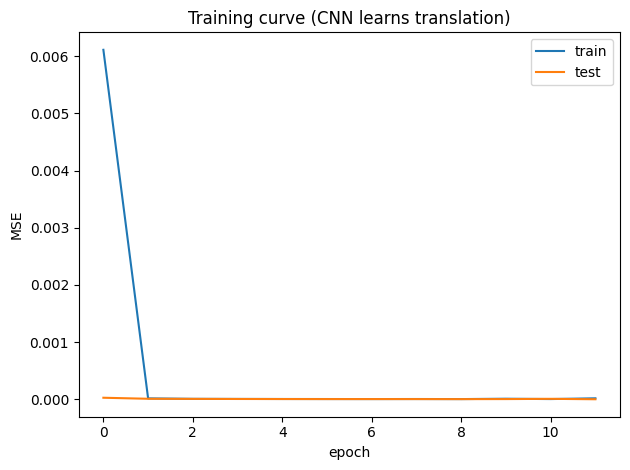

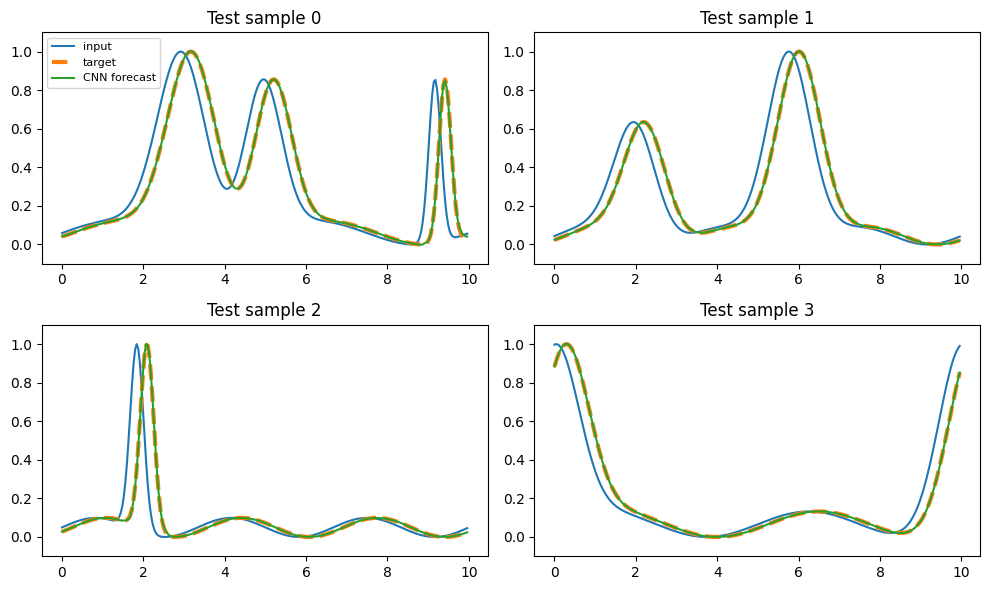

Saved: cnn_translation_loss.png, cnn_translation_examples.png


In [3]:
# ============================================================
# Cell 3: Train + test + visualize results
# ============================================================
from torch.utils.data import TensorDataset, DataLoader

# Convert to torch
Xtr = torch.from_numpy(X_train)[:, None, :]   # (n,1,N)
Ytr = torch.from_numpy(Y_train)[:, None, :]

Xte = torch.from_numpy(X_test)[:, None, :]
Yte = torch.from_numpy(Y_test)[:, None, :]

train_loader = DataLoader(TensorDataset(Xtr, Ytr), batch_size=64, shuffle=True)
test_loader  = DataLoader(TensorDataset(Xte, Yte), batch_size=128, shuffle=False)

opt = torch.optim.Adam(model.parameters(), lr=2e-3)
loss_fn = nn.MSELoss()

def eval_mse(loader):
    model.eval()
    tot, n = 0.0, 0
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device); yb = yb.to(device)
            yp, _ = model(xb)
            loss = loss_fn(yp, yb).item()
            tot += loss * xb.size(0)
            n += xb.size(0)
    return tot / n

# Train
epochs = 12
train_losses = []
test_losses  = []

for ep in range(1, epochs+1):
    model.train()
    tot, n = 0.0, 0
    for xb, yb in train_loader:
        xb = xb.to(device); yb = yb.to(device)
        opt.zero_grad()
        yp, _ = model(xb)
        loss = loss_fn(yp, yb)
        loss.backward()
        opt.step()
        tot += loss.item() * xb.size(0)
        n += xb.size(0)

    tr = tot / n
    te = eval_mse(test_loader)
    train_losses.append(tr)
    test_losses.append(te)
    print(f"ep {ep:02d} | train {tr:.4e} | test {te:.4e}")

# Plot loss curve
plt.figure()
plt.plot(train_losses, label="train")
plt.plot(test_losses, label="test")
plt.title("Training curve (CNN learns translation)")
plt.xlabel("epoch")
plt.ylabel("MSE")
plt.legend()
plt.tight_layout()
plt.savefig("cnn_translation_loss.png", dpi=150)
plt.show()

# Visualize several test examples
model.eval()
with torch.no_grad():
    idxs = rng.integers(0, n_test, size=4)
    xb = Xte[idxs].to(device)
    yb = Yte[idxs].to(device)
    yp, _ = model(xb)
    xb = xb.cpu().numpy()[:,0]
    yb = yb.cpu().numpy()[:,0]
    yp = yp.cpu().numpy()[:,0]

plt.figure(figsize=(10,6))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.plot(x, xb[i], label="input")
    plt.plot(x, yb[i], "--", label="target", linewidth='3')
    plt.plot(x, yp[i], label="CNN forecast")
    plt.ylim(-0.1, 1.1)
    plt.title(f"Test sample {i}")
    if i == 0:
        plt.legend(fontsize=8)
plt.tight_layout()
plt.savefig("cnn_translation_examples.png", dpi=150)
plt.show()

print("Saved: cnn_translation_loss.png, cnn_translation_examples.png")


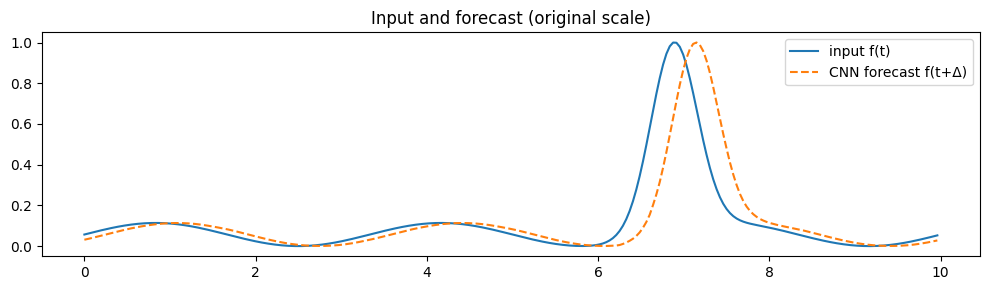

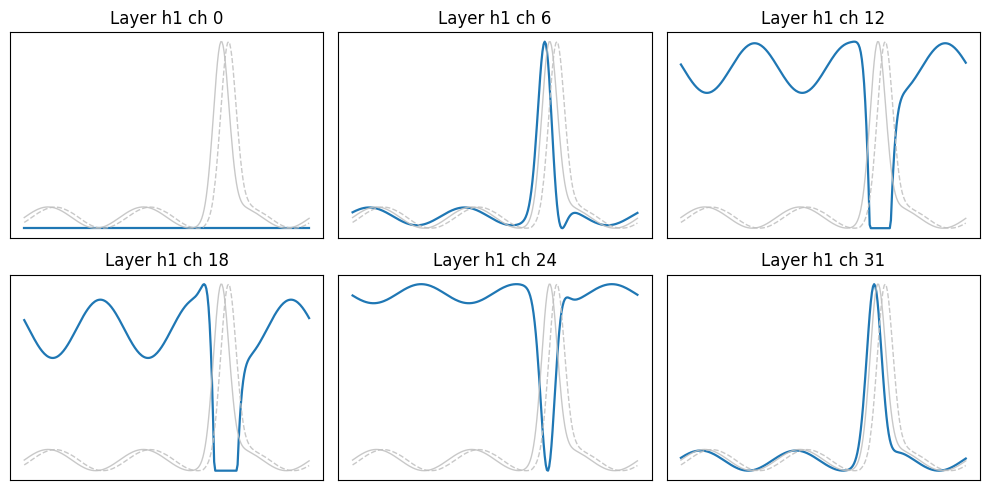

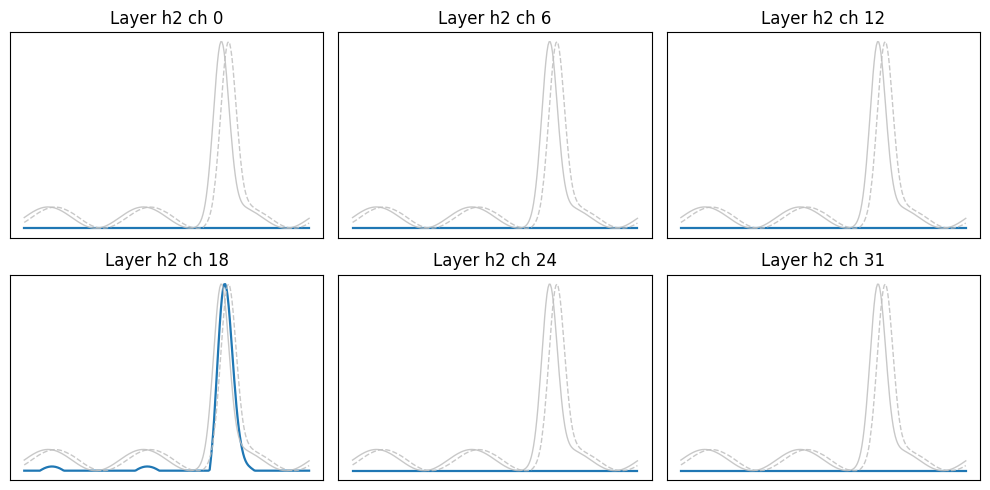

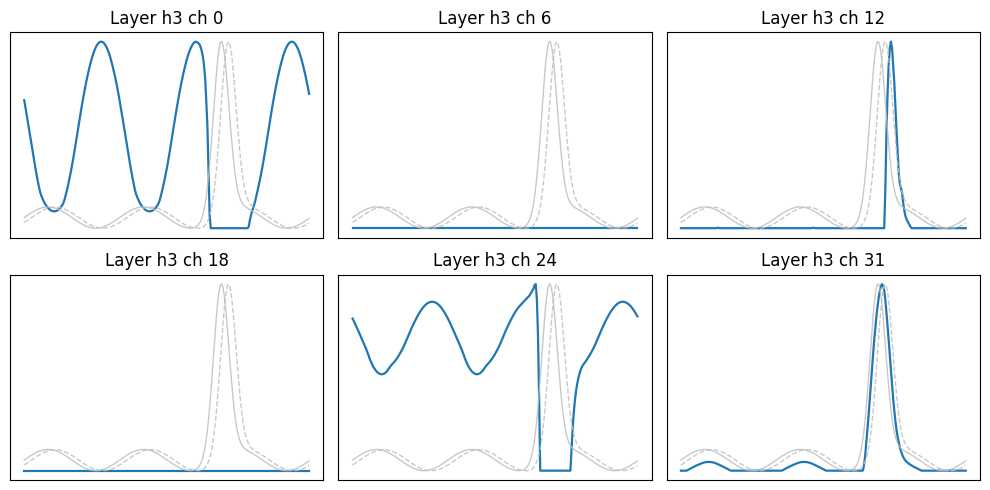

Saved:
  cnn_translation_input_output.png
  cnn_translation_features_h1.png
  cnn_translation_features_h2.png
  cnn_translation_features_h3.png


In [4]:
# ============================================================
# Cell 4: Visualize internal CNN layers (feature maps)
# with scaled input/output overlays in every subplot
# ============================================================
import numpy as np
import matplotlib.pyplot as plt

model.eval()

# pick one sample
i0 = int(rng.integers(0, n_test))
x0 = Xte[i0:i0+1].to(device)

with torch.no_grad():
    yhat, feats = model(x0)

x0_np   = x0.cpu().numpy()[0,0]
yhat_np = yhat.cpu().numpy()[0,0]

h1 = feats["h1"].cpu().numpy()[0]  # (C,N)
h2 = feats["h2"].cpu().numpy()[0]
h3 = feats["h3"].cpu().numpy()[0]

def _rescale_to_range(arr, out_min, out_max):
    """Rescale 1D array to [out_min, out_max]."""
    amin = float(np.min(arr))
    amax = float(np.max(arr))
    if abs(amax - amin) < 1e-12:
        return np.full_like(arr, 0.5*(out_min+out_max), dtype=np.float64)
    z = (arr - amin) / (amax - amin + 1e-12)
    return out_min + z * (out_max - out_min)

def plot_features(H, title, x_ref, y_ref, n_show=6):
    """
    Plot feature channels and overlay scaled reference curves:
      - x_ref: input f(t)   (scaled to each channel range)
      - y_ref: output f(t+Δ) (scaled to each channel range, dashed)
    """
    C = H.shape[0]
    chans = np.linspace(0, C-1, n_show, dtype=int)

    plt.figure(figsize=(10,5))
    for j, c in enumerate(chans):
        ax = plt.subplot(2,3,j+1)

        hc = H[c]
        ax.plot(x, hc, linewidth=1.6)

        hmin, hmax = float(np.min(hc)), float(np.max(hc))
        if abs(hmax - hmin) < 1e-12:
            hmax = hmin + 1e-12

        # scaled references to the feature range
        xr = _rescale_to_range(x_ref, hmin, hmax)
        yr = _rescale_to_range(y_ref, hmin, hmax)

        ax.plot(x, xr, color="0.75", linewidth=1.0, alpha=0.85)
        ax.plot(x, yr, color="0.75", linewidth=1.0, alpha=0.85, linestyle="--")

        ax.set_title(f"{title} ch {c}")
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()

# ------------------------------------------------------------
# Panel 1: input + output (original scale)
# ------------------------------------------------------------
plt.figure(figsize=(10,3))
plt.plot(x, x0_np, label="input f(t)")
plt.plot(x, yhat_np, label="CNN forecast f(t+Δ)", linestyle="--")
plt.title("Input and forecast (original scale)")
plt.legend()
plt.tight_layout()
plt.savefig("cnn_translation_input_output.png", dpi=150)
plt.show()

# ------------------------------------------------------------
# Feature maps with scaled overlays
# ------------------------------------------------------------
plot_features(h1, "Layer h1", x_ref=x0_np, y_ref=yhat_np, n_show=6)
plt.savefig("cnn_translation_features_h1.png", dpi=150)
plt.show()

plot_features(h2, "Layer h2", x_ref=x0_np, y_ref=yhat_np, n_show=6)
plt.savefig("cnn_translation_features_h2.png", dpi=150)
plt.show()

plot_features(h3, "Layer h3", x_ref=x0_np, y_ref=yhat_np, n_show=6)
plt.savefig("cnn_translation_features_h3.png", dpi=150)
plt.show()

print("Saved:")
print("  cnn_translation_input_output.png")
print("  cnn_translation_features_h1.png")
print("  cnn_translation_features_h2.png")
print("  cnn_translation_features_h3.png")


In [5]:
# ============================================================
# Report: number of channels per layer + which ones are shown
# ============================================================
import numpy as np

def channels_shown(C, n_show=6):
    """Replicate the channel selection logic used in plot_features()."""
    return np.linspace(0, C-1, n_show, dtype=int)

# Feature tensor shapes (already computed in your Cell 4)
# h1, h2, h3 are numpy arrays with shape (C, N)

C1, N1 = h1.shape
C2, N2 = h2.shape
C3, N3 = h3.shape

print("\nCNN FEATURE MAP SUMMARY")
print("="*70)
print(f"Input: 1 variable on {N} grid points (shape: 1 x {N})")
print(f"Output: 1 variable on {N} grid points (shape: 1 x {N})")
print("-"*70)

print(f"Layer h1: {C1} channels  (shape: {C1} x {N1})")
print(f"Layer h2: {C2} channels  (shape: {C2} x {N2})")
print(f"Layer h3: {C3} channels  (shape: {C3} x {N3})")

n_show = 6
print("\nChannels displayed in feature figures (n_show=6):")
print(f"  h1: {channels_shown(C1, n_show=n_show).tolist()}")
print(f"  h2: {channels_shown(C2, n_show=n_show).tolist()}")
print(f"  h3: {channels_shown(C3, n_show=n_show).tolist()}")

print("\nInterpretation:")
print("  - each channel is one learned feature variable")
print("  - we visualize 6 representative channels per layer")
print("  - channels are sampled evenly from [0 .. C-1]")
print("="*70)



CNN FEATURE MAP SUMMARY
Input: 1 variable on 256 grid points (shape: 1 x 256)
Output: 1 variable on 256 grid points (shape: 1 x 256)
----------------------------------------------------------------------
Layer h1: 32 channels  (shape: 32 x 256)
Layer h2: 32 channels  (shape: 32 x 256)
Layer h3: 32 channels  (shape: 32 x 256)

Channels displayed in feature figures (n_show=6):
  h1: [0, 6, 12, 18, 24, 31]
  h2: [0, 6, 12, 18, 24, 31]
  h3: [0, 6, 12, 18, 24, 31]

Interpretation:
  - each channel is one learned feature variable
  - we visualize 6 representative channels per layer
  - channels are sampled evenly from [0 .. C-1]


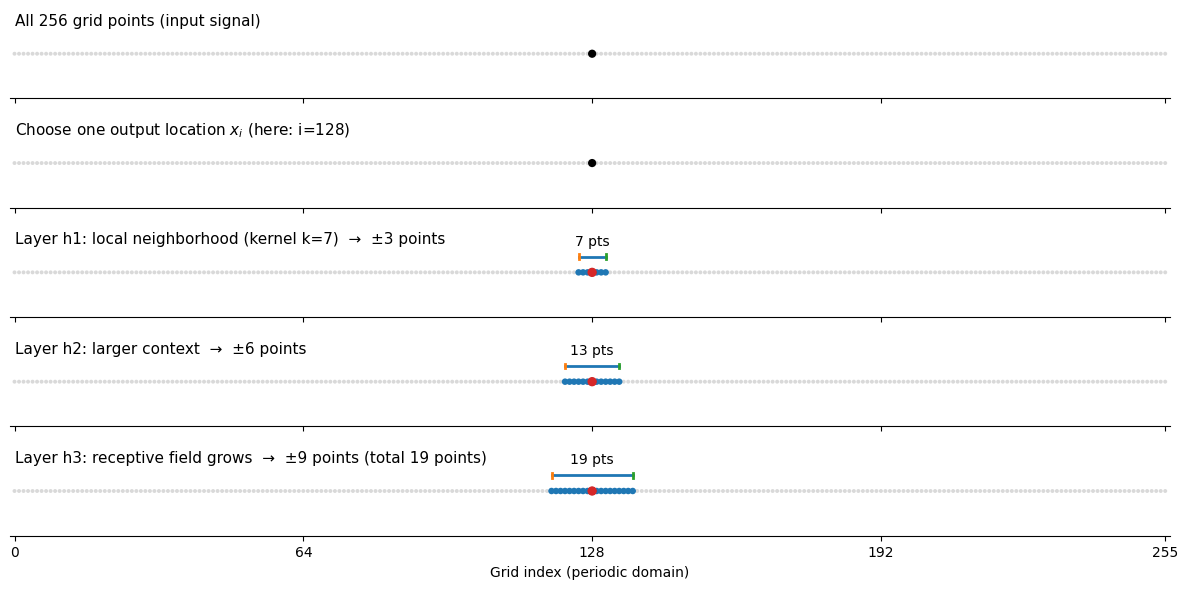

Saved: cnn_layers_influence.png


In [6]:
# ============================================================
# Create illustration: receptive field grows with CNN layers
# Saves: cnn_layers_influence.png
# ============================================================
import numpy as np
import matplotlib.pyplot as plt

# ---- settings ----
N = 256
k = 7
n_layers = 3
pad = k // 2

# choose central point to highlight
i0 = N // 2

# receptive half-width per layer (for stacked convs with stride=1)
# after L layers: halfwidth = L * pad
halfwidths = [0, pad, 2*pad, 3*pad]  # input point only, h1, h2, h3
labels = [
    "All 256 grid points (input signal)",
    f"Choose one output location $x_i$ (here: i={i0})",
    f"Layer h1: local neighborhood (kernel k={k})  →  ±{halfwidths[1]} points",
    f"Layer h2: larger context  →  ±{halfwidths[2]} points",
    f"Layer h3: receptive field grows  →  ±{halfwidths[3]} points (total 19 points)"
]

# ---- helper: indices in periodic wrap-around window ----
def periodic_window(center, halfwidth):
    idx = np.arange(center - halfwidth, center + halfwidth + 1)
    return np.mod(idx, N)

# ---- figure canvas ----
fig, axes = plt.subplots(5, 1, figsize=(12, 6), sharex=True)
x = np.arange(N)

for r, ax in enumerate(axes):
    ax.set_xlim(-1, N)
    ax.set_ylim(-1, 1)
    ax.set_yticks([])
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    # base: all points (grey)
    ax.scatter(x, np.zeros_like(x), s=8, c="0.85", edgecolors="none")

    # highlight chosen point
    ax.scatter([i0], [0], s=35, c="black", edgecolors="none", zorder=5)

    # now layer-specific influence
    if r >= 2:
        hw = halfwidths[r-1]  # r=2→h1, r=3→h2, r=4→h3
        infl = periodic_window(i0, hw)

        # highlight influenced points
        ax.scatter(infl, np.zeros_like(infl), s=22, c="tab:blue", edgecolors="none", zorder=4)

        # make center point stand out
        ax.scatter([i0], [0], s=45, c="tab:red", edgecolors="none", zorder=6)

        # show a bracket-ish line for the influence range (non-wrapping display only)
        left = i0 - hw
        right = i0 + hw
        ax.plot([left, right], [0.35, 0.35], linewidth=2.0)
        ax.plot([left, left], [0.30, 0.40], linewidth=2.0)
        ax.plot([right, right], [0.30, 0.40], linewidth=2.0)

        ax.text(i0, 0.55, f"{2*hw+1} pts", ha="center", va="bottom", fontsize=10)

    # titles
    ax.text(0, 0.75, labels[r], fontsize=11, ha="left", va="center")

# x-axis formatting
axes[-1].set_xticks([0, 64, 128, 192, 255])
axes[-1].set_xlabel("Grid index (periodic domain)")

plt.tight_layout()
plt.savefig("cnn_layers_influence.png", dpi=200)
plt.show()

print("Saved: cnn_layers_influence.png")

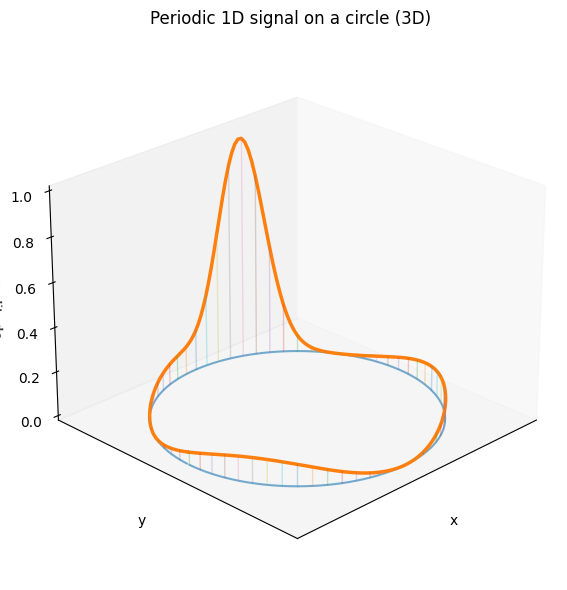

Saved: signal_on_circle_3d.png


In [7]:
# ============================================================
# 3D visualization: periodic signal on a circle
# Saves: signal_on_circle_3d.png
# ============================================================
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# Use an existing signal if available; otherwise pick one from X_test
try:
    f = x0_np.copy()   # from your previous cell
except NameError:
    f = X_test[np.random.randint(0, len(X_test))].copy()

N = len(f)

# angle around circle
theta = np.linspace(0, 2*np.pi, N, endpoint=False)

# circle radius
R = 1.0

# map to 3D: (x,y) circle, z = amplitude
Xc = R * np.cos(theta)
Yc = R * np.sin(theta)
Zc = f

# also draw the circle baseline (z=0) for reference
Z0 = np.zeros_like(Zc)

plt.figure(figsize=(10, 6))
ax = plt.axes(projection="3d")

# baseline circle
ax.plot(Xc, Yc, Z0, linewidth=1.5, alpha=0.6)

# signal curve
ax.plot(Xc, Yc, Zc, linewidth=2.5)

# optionally add faint vertical lines to show amplitude
step = max(1, N // 64)
for i in range(0, N, step):
    ax.plot([Xc[i], Xc[i]], [Yc[i], Yc[i]], [0, Zc[i]], alpha=0.25, linewidth=1)

ax.set_title("Periodic 1D signal on a circle (3D)", pad=15)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("amplitude")

# nicer view angle
ax.view_init(elev=25, azim=45)

# clean look
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.savefig("signal_on_circle_3d.png", dpi=200)
plt.show()

print("Saved: signal_on_circle_3d.png")